# Data Exploration of the StatsBomb Dataset

This notebook focuses on a **data exploration** of the [StatsBomb dataset](https://github.com/statsbomb/open-data) using the `statsbombpy` library. The goal is to analyze and structure information related to shots taken by players, which will later serve as the foundation for developing an expected goals (xG) model.

`statsbombpy` is a Python API that provides easy access to StatsBomb’s open-data, allowing users to directly query matches, events, and other football-related information without manual downloads.

This below are the steps taken in this notebook:
1. Explore and analyze the relevant information from the StatsBomb dataset  
2. Investigate specific matches to understand how `Shot` events are structured  


## 1) Analysis of the Dataset

In [17]:
from statsbombpy import sb
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

### 1.1) Exploration of Available Competitions and Seasons

Here, the exploration of the StatsBomb data was carried out to identify the available competitions and seasons in the dataset.
For each competition–season pair, the total number of matches was collected into a dataframe and printed as a summary table. Also the global number of competitions and matches are stored in the final row of the created dataframe.

In [18]:
# Load competitions
competitions = sb.competitions()
competitions.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-09-28T20:46:38.893391,2025-07-06T04:26:07.636270,2025-07-06T04:26:07.636270,2024-09-28T20:46:38.893391
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-09-28T01:57:35.846538,None,None,2024-09-28T01:57:35.846538
3,16,4,Europe,Champions League,male,False,False,2018/2019,2025-05-08T15:10:50.835274,2021-06-13T16:17:31.694,None,2025-05-08T15:10:50.835274
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [19]:
competition_list = []
competitions = sb.competitions()

# Iterate through each competition and season to gather match counts
for _, row in tqdm(competitions.iterrows(), total=competitions.shape[0], desc="Processing competitions"):

    # Collect competition and season information
    comp_id = row["competition_id"]
    season_id = row["season_id"]

    # Fetch matches for the given competition and season
    matches = sb.matches(competition_id=comp_id, season_id=season_id)

    # Append the data to rows
    competition_list.append({
        "Competition": row["competition_name"],
        "Season": row["season_name"],
        "Gender": (str(row["competition_gender"]) or "").title(),  # .title() to capitalize
        "Matches": int(matches.shape[0]),
    })

# Create a DataFrame from the competition list
df = pd.DataFrame(competition_list)

# Sort by first season year then competition
df["Season_Start"] = df["Season"].str[:4].astype(int)
df = (
    df.sort_values(["Season_Start", "Competition"])
      .drop(columns="Season_Start")
      .reset_index(drop=True)
)

# Calculate totals
total_matches = int(df["Matches"].sum())
total_pairs = len(df)  # unique (Competition, Season)
total_unique_competitions = df["Competition"].nunique()

total_row = pd.DataFrame([{
    "Competition": "TOTAL",
    "Season": f"{total_pairs} pairs | {total_unique_competitions} competitions",
    "Gender": "",
    "Matches": total_matches,
}])

df_competitions = pd.concat([df, total_row], ignore_index=True)


Processing competitions: 100%|██████████| 75/75 [00:16<00:00,  4.46it/s]


In [20]:
# Display the DataFrame as a table
df_competitions["Matches"] = df_competitions["Matches"].map("{:,}".format) # Format matches for better readability
print("\nAvailable Competitions in StatsBomb Open Data\n")
print(tabulate(df_competitions, headers="keys", tablefmt="grid", showindex=False))


Available Competitions in StatsBomb Open Data

+-------------------------+----------------------------+----------+-----------+
| Competition             | Season                     | Gender   | Matches   |
+=========================+============================+==========+===========+
| FIFA World Cup          | 1958                       | Male     | 2         |
+-------------------------+----------------------------+----------+-----------+
| FIFA World Cup          | 1962                       | Male     | 1         |
+-------------------------+----------------------------+----------+-----------+
| Champions League        | 1970/1971                  | Male     | 1         |
+-------------------------+----------------------------+----------+-----------+
| FIFA World Cup          | 1970                       | Male     | 6         |
+-------------------------+----------------------------+----------+-----------+
| Champions League        | 1971/1972                  | Male     | 1   

#### Saving the Competition DataFrame

The resulting DataFrame is saved as a `csv` file in the `/data` folder for later use.

In [21]:
import os

# Define relative path to the data folder
data_dir = os.path.join("..", "data")
os.makedirs(data_dir, exist_ok=True)

# Choose a clear filename with today's date
filename_base = "df_competitions_2025"
csv_path = os.path.join(data_dir, f"{filename_base}.csv")

# Save DataFrame
df_competitions.to_csv(csv_path, index=False)

print(f"DataFrame saved successfully:\n- {csv_path}")

DataFrame saved successfully:
- ../data/df_competitions_2025.csv


### 1.2) Load the Saved Dataset

In [22]:
from pathlib import Path

# LOAD THE SAVED COMPETITION DATA

# Path to data
data_dir = Path("..") / "data"

# Define the source path for the saved DataFrame
src_path = data_dir / "df_competitions_2025.csv"

print(f"Loading {src_path.name}")

# Load DataFrame
df_comp = pd.read_csv(src_path)

# Clean up DataFrame (e.g., remove TOTAL row, extract years, convert matches to numeric)
df_comp = (
    df_comp
    .query("Competition != 'TOTAL'")  # drop TOTAL row
    .assign(
        Season_Start=lambda d: pd.to_numeric(d["Season"].astype(str).str.extract(r"(\d{4})")[0], errors="coerce"),      # extract starting year, errors='coerce' to handle any non-numeric values
        Matches=lambda d: pd.to_numeric(d["Matches"].astype(str).str.replace(r"\D", "", regex=True), errors="coerce")   # remove non-numeric characters
    )
    .astype({"Season_Start": "Int64", "Matches": "Int64"})
    .reset_index(drop=True)
)

print(f"Rows: {len(df_comp)} | Unique competitions: {df_comp['Competition'].nunique()}")

df_comp.head()


Loading df_competitions_2025.csv
Rows: 75 | Unique competitions: 21


,Competition,Season,Gender,Matches,Season_Start
0,FIFA World Cup,1958,Male,2,1958
1,FIFA World Cup,1962,Male,1,1962
2,Champions League,1970/1971,Male,1,1970
3,FIFA World Cup,1970,Male,6,1970
4,Champions League,1971/1972,Male,1,1971


### 1.3) Competition and Match Distribution

The saved competition dataset is used to create two main visualizations:

1. **Competitions and matches by competition type** – this shows, for each competition, how many seasons it has appeared in and the total number of matches played within it.

2. **Competitions and matches over time** – this illustrates how the number of competitions and the total number of matches have changed across different seasons.

#### Plot Competitions and Matches by Competition Type

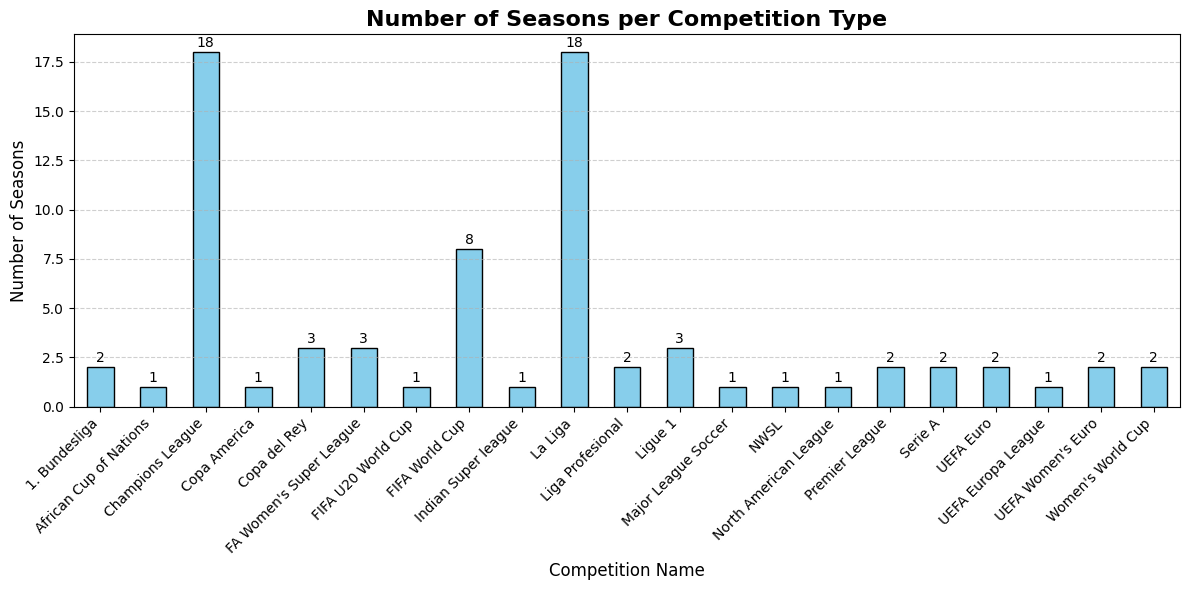

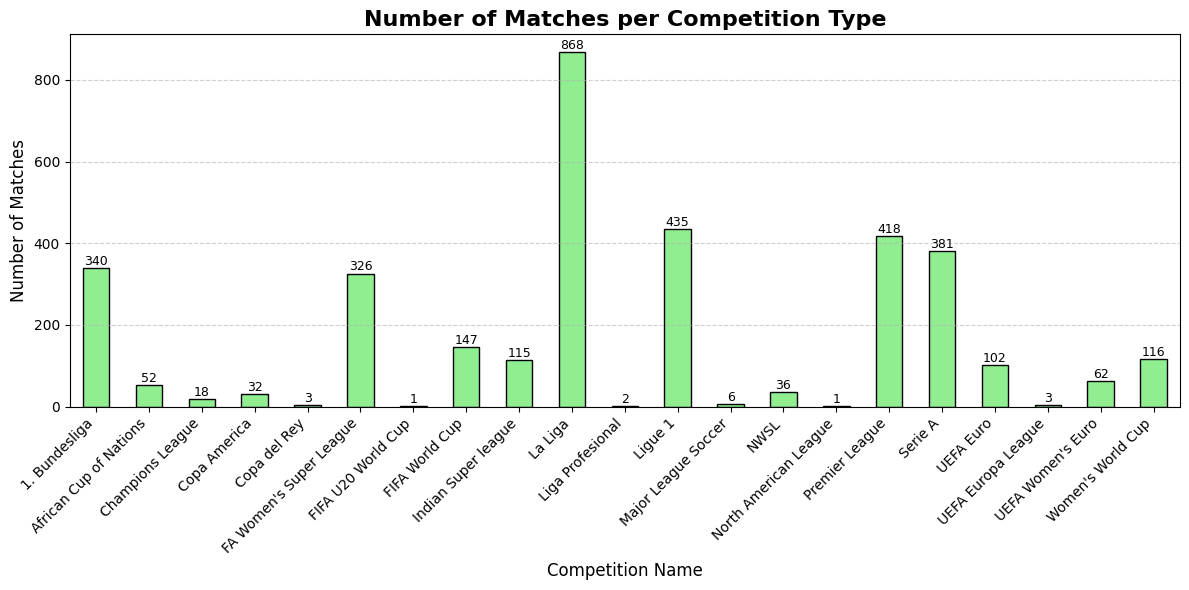

In [23]:
import matplotlib.pyplot as plt

# Check if df_comp exists in the current environment
if "df_comp" not in globals():
    raise RuntimeError("df_comp not found. Please run cell \"1.3) Load the saved dataset first\"")

# Count how many seasons exist for each competition
seasons_per_comp = df_comp.groupby("Competition")["Season_Start"].nunique()

# Sum of matches for each competition
matches_per_comp = df_comp.groupby("Competition")["Matches"].sum()

# Plot: number of seasons per competition
plt.figure(figsize=(12,6))
bars = seasons_per_comp.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Number of Seasons per Competition Type", fontsize=16, weight="bold")
plt.ylabel("Number of Seasons", fontsize=12)
plt.xlabel("Competition Name", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(seasons_per_comp):
    plt.text(i, v + 0.1, str(v), ha="center", va="bottom", fontsize=10, color="black")  # +0.2 to avoid overlap

plt.tight_layout()
plt.show()


# Plot: number of matches per competition
plt.figure(figsize=(12,6))
bars = matches_per_comp.plot(kind="bar", color="lightgreen", edgecolor="black")

plt.title("Number of Matches per Competition Type", fontsize=16, weight="bold")
plt.ylabel("Number of Matches", fontsize=12)
plt.xlabel("Competition Name", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(matches_per_comp):
    plt.text(i, v + 0.1, str(v), ha="center", va="bottom", fontsize=9)  # +0.2 to avoid overlap

plt.tight_layout()
plt.show()

#### Plot Competitions and Matches by Year

> **NOTE**: Competitions and matches are aggregated by **season start year** (the first 4-digit year in the "Season" column), so each competition is counted according to its starting year.  

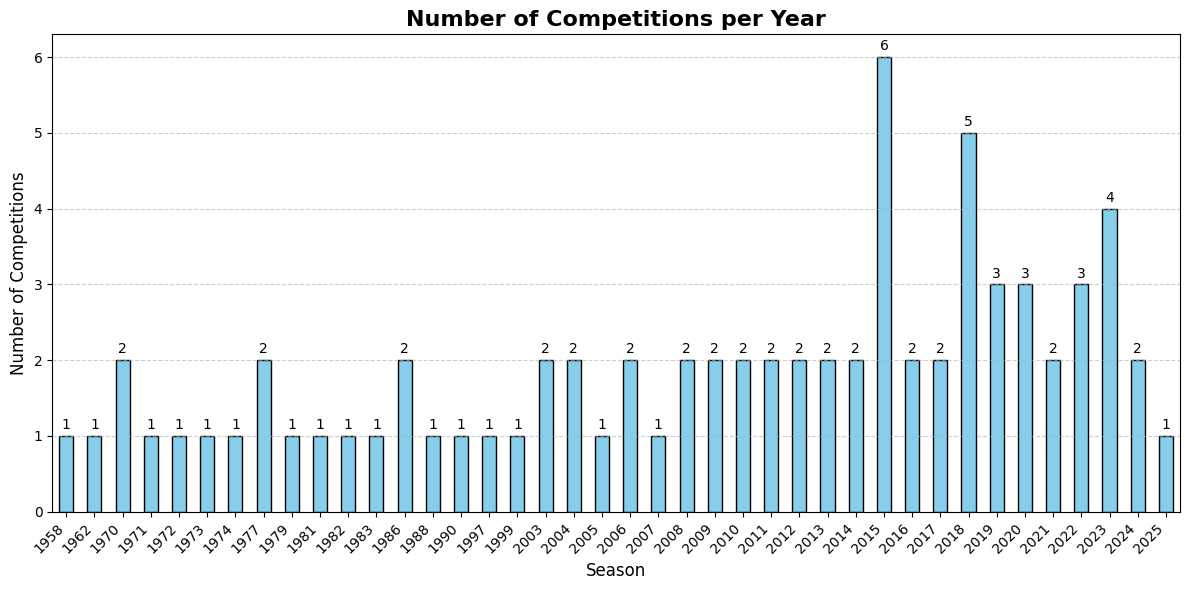

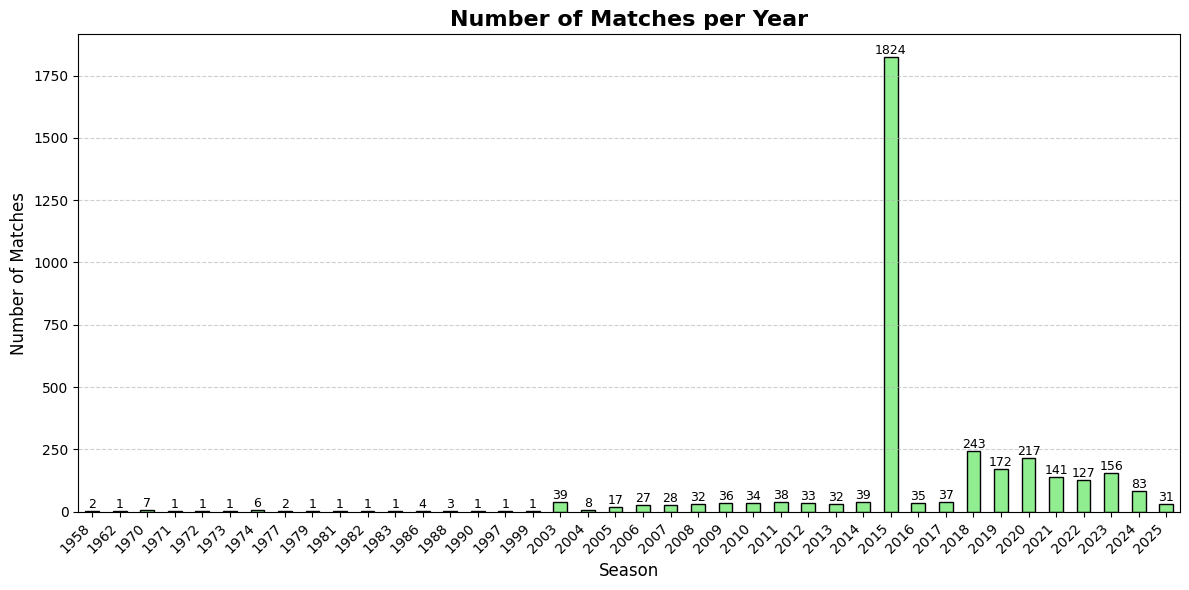

In [24]:
import matplotlib.pyplot as plt

# Check if df_comp exists in the current environment
if "df_comp" not in globals():
    raise RuntimeError("df_comp not found. Please run cell \"1.3) Load the saved dataset first\"")

# Count how many competitions exist each year
competitions_per_year = df_comp.groupby("Season_Start")["Competition"].nunique()

# Sum of matches per year
matches_per_year = df_comp.groupby("Season_Start")["Matches"].sum()

# Plot: number of competitions per year
plt.figure(figsize=(12,6))
bars = competitions_per_year.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Number of Competitions per Year", fontsize=16, weight="bold")
plt.ylabel("Number of Competitions", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(competitions_per_year):
    plt.text(i, v + 0.05, str(v), ha="center", va="bottom", fontsize=10, color="black")

plt.tight_layout()
plt.show()

# Plot: number of matches per year
plt.figure(figsize=(12,6))
bars = matches_per_year.plot(kind="bar", color="lightgreen", edgecolor="black")

plt.title("Number of Matches per Year", fontsize=16, weight="bold")
plt.ylabel("Number of Matches", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(matches_per_year):
    plt.text(i, v + 0.1, str(v), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


### 1.4) Info on Competition and Matches Gender  

Overview of the competitions by gender. A simple print lists the unique gender values available while a bar chart visualizes how many competitions exist for each gender category.  

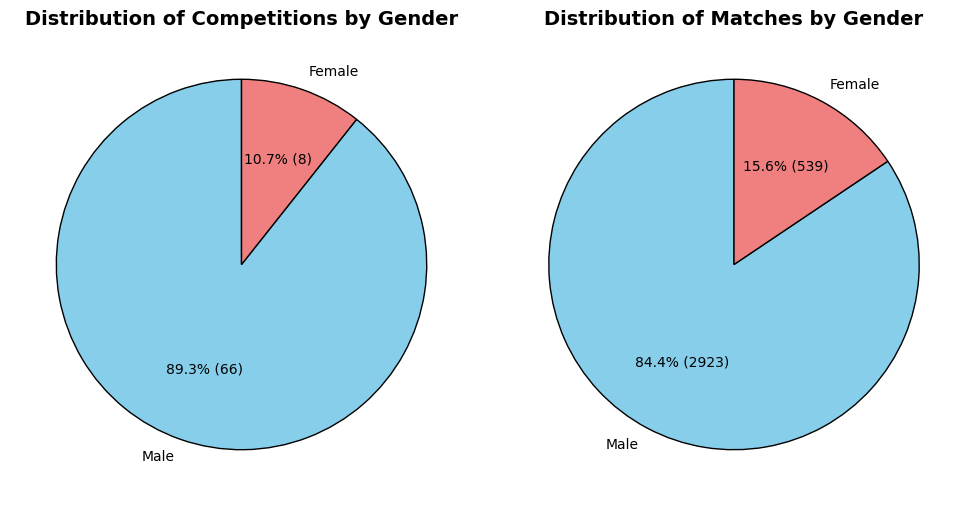

In [25]:
import matplotlib.pyplot as plt

# Check if df_comp exists in the current environment
if "df_comp" not in globals():
    raise RuntimeError("df_comp not found. Please run cell \"1.3) Load the saved dataset first\"")

# Compute the number of competitions per gender
gender_counts = df_comp["Gender"].value_counts()

# Compute the number of matches per gender
matches_per_gender = df_comp.groupby("Gender")["Matches"].sum()

# Force a consistent order of categories (Male first, Female second)
order = ["Male", "Female"]
gender_counts = gender_counts.reindex(order).dropna()
matches_per_gender = matches_per_gender.reindex(order).dropna()

# Define consistent colors for genders
color_map = {"Male": "skyblue", "Female": "lightcoral"}

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Competitions by gender
gender_counts.plot(
    kind="pie",
    labels=gender_counts.index,                                         # labels are the gender categories
    autopct=lambda p: f"{p:.1f}% ({int(p*sum(gender_counts)/100)})",    # show % and absolute count
    startangle=90,                                                      # rotate the chart so it starts from the top
    counterclock=True,                                                  # wedges are drawn counterclockwise
    colors=[color_map[g] for g in gender_counts.index],                 # apply consistent colors
    wedgeprops={"edgecolor": "black"},                                  # black borders around wedges
    ax=axes[0]                                                          # plot in the first subplot
)
axes[0].set_title("Distribution of Competitions by Gender", fontsize=14, fontweight="bold")
axes[0].set_ylabel("")  # remove y-axis label

# Plot 2: Matches by gender
matches_per_gender.plot(
    kind="pie",
    labels=matches_per_gender.index,                                       # labels are the gender categories
    autopct=lambda p: f"{p:.1f}% ({int(p*sum(matches_per_gender)/100)})",  # show % and absolute count
    startangle=90,                                                         # same rotation as the first chart
    counterclock=True,                                                     # same direction to keep wedges aligned
    colors=[color_map[g] for g in matches_per_gender.index],               # apply consistent colors
    wedgeprops={"edgecolor": "black"},                                     # black borders around wedges
    ax=axes[1]                                                             # plot in the second subplot
)
axes[1].set_title("Distribution of Matches by Gender", fontsize=14, fontweight="bold")
axes[1].set_ylabel("")  # remove y-axis label

# Adjust layout so titles fit nicely
plt.tight_layout()

# Display the figure
plt.show()


### 1.5) Info on the Availability of 360 Data

StatsBomb provides two types of open data: **event data** (passes, shots, tackles, etc.) and **360 freeze-frame data**.  
The 360 dataset adds contextual information: for example, for each shot, it captures the positions of all players around the ball in that  moment.

However, **360 data is not available for all competitions** in the **open-data** repository (free version).  
- Most competitions only provide **event data**.  
- Only a few competitions include 360 freeze frames.  

Below, the code iterates over every competition-season in StatsBomb’s open-data repository and:  
1. Counts the total number of matches available
2. Tries to fetch 360 freeze-frame data and counts how many matches are covered
3. Calculates the percentage of matches that include 360 data

#### Per-match analysis via `sb.frames(match_id)`

The per-match analysis of 360 data is carried out by using `sb.frames(match_id, fmt="json")`, which returns a list of frames associated with a given match. When the returned list is non-empty, it confirms that 360 data is available for that match. This approach provides a direct verification of coverage at the level of individual matches, ensuring that the presence of tracking data is explicitly checked rather than inferred.


In [44]:
# Cell 1 — Build per-match coverage table AND collect the list of match_ids that have 360

# One-cell notebook: compute 360 coverage by checking each match with sb.frames(match_id) 
# Notes: 
# - More accurate than competition_frames because it inspects each match directly. 
# - Slower (loops over all matches).

import pandas as pd
from tqdm import tqdm
from statsbombpy import sb

# Load all open-data competitions
comps = sb.competitions()

rows = []
match_ids_360_all = set()  # will store every match_id that actually has 360

for _, row in tqdm(comps.iterrows(), total=len(comps), desc="Checking 360 data (per-match)"):
    comp_id = int(row["competition_id"])
    season_id = int(row["season_id"])
    comp_name = str(row.get("competition_name", ""))
    season_name = str(row.get("season_name", ""))
    country = str(row.get("country_name", ""))

    # Get all matches for this competition-season
    try:
        matches = sb.matches(competition_id=comp_id, season_id=season_id)
        match_ids = matches["match_id"].tolist() if isinstance(matches, pd.DataFrame) else []
    except Exception:
        match_ids = []
    total_matches = len(match_ids)

    # Count how many matches actually have 360 frames by calling sb.frames per match
    matches_360 = 0
    for mid in match_ids:
        try:
            f = sb.frames(match_id=mid, fmt="json")
            if isinstance(f, list) and len(f) > 0:
                matches_360 += 1
                match_ids_360_all.add(int(mid))  # collect the id
        except Exception:
            pass

    # Percentage coverage
    perc = (matches_360 / total_matches * 100) if total_matches > 0 else 0.0

    rows.append([
        season_name,
        comp_name,
        total_matches,
        matches_360,
        f"{perc:.1f}%"
    ])

# Final per-match summary table
df_per_match = pd.DataFrame(
    rows,
    columns=["Season", "Competition", "Total Matches", "Matches with 360", "% 360"]
).sort_values(["Season", "Competition"], kind="stable").reset_index(drop=True)

# Sorted list of all match_ids that have 360
match_ids_360 = sorted(match_ids_360_all)


Checking 360 data (per-match): 100%|██████████| 75/75 [16:41<00:00, 13.36s/it] 


In [63]:
# Print the summary tables and the list of match_ids with 360

from tabulate import tabulate

# Full summary table
print("\nCompetition-Season summary with 360 data (per-match check):")
print(tabulate(df_per_match, headers="keys", tablefmt="grid", showindex=False))

# Global summary
total_all = int(df_per_match["Total Matches"].sum()) if not df_per_match.empty else 0
total_360 = int(df_per_match["Matches with 360"].sum()) if not df_per_match.empty else 0
perc_global = (total_360 / total_all * 100) if total_all > 0 else 0.0

print("\nGlobal summary:")
print(f"Total matches: {total_all}")
print(f"Matches with 360: {total_360}")
print(f"Percentage: {perc_global:.1f}%")

# Compact view: only rows that have 360 coverage
df_360_per_match = df_per_match[df_per_match["Matches with 360"] > 0].reset_index(drop=True)
print("\nRows with 360 coverage only:")
print(tabulate(df_360_per_match, headers="keys", tablefmt="github", showindex=False))



Competition-Season summary with 360 data (per-match check):
+-----------+-------------------------+-----------------+--------------------+---------+
| Season    | Competition             |   Total Matches |   Matches with 360 | % 360   |
+===========+=========================+=================+====================+=========+
| 1958      | FIFA World Cup          |               2 |                  0 | 0.0%    |
+-----------+-------------------------+-----------------+--------------------+---------+
| 1962      | FIFA World Cup          |               1 |                  0 | 0.0%    |
+-----------+-------------------------+-----------------+--------------------+---------+
| 1970      | FIFA World Cup          |               6 |                  0 | 0.0%    |
+-----------+-------------------------+-----------------+--------------------+---------+
| 1970/1971 | Champions League        |               1 |                  0 | 0.0%    |
+-----------+-------------------------+----------

In [70]:
# Print the list of match_ids with 360
print(f"All match_ids with 360 infos (total={len(match_ids_360)}):\n")
for mid in match_ids_360:
    print(mid)

All match_ids with 360 infos (total=323):

3788741
3788742
3788743
3788744
3788745
3788746
3788747
3788748
3788749
3788750
3788751
3788752
3788753
3788754
3788755
3788756
3788757
3788758
3788759
3788760
3788761
3788762
3788763
3788764
3788765
3788766
3788767
3788768
3788769
3788770
3788771
3788772
3788773
3788774
3788775
3788776
3794685
3794686
3794687
3794688
3794689
3794690
3794691
3794692
3795107
3795108
3795109
3795187
3795220
3795221
3795506
3835319
3835320
3835321
3835322
3835323
3835324
3835325
3835326
3835327
3835328
3835329
3835330
3835331
3835332
3835333
3835334
3835335
3835336
3835337
3835339
3835340
3835341
3844384
3844385
3844386
3844387
3845507
3847567
3857254
3857255
3857256
3857257
3857258
3857259
3857260
3857261
3857262
3857263
3857264
3857265
3857266
3857267
3857268
3857269
3857270
3857271
3857272
3857273
3857274
3857275
3857276
3857277
3857278
3857279
3857280
3857281
3857282
3857283
3857284
3857285
3857286
3857287
3857288
3857289
3857290
3857291
3857292
3857293
38572

#### Saving the DataFrame  

The cell below saves the selected **DataFrame** as a **CSV** file.


In [ ]:
import os

# Define relative path to the data folder
data_dir = os.path.join("..", "data")
os.makedirs(data_dir, exist_ok=True)

# Choose a clear filename with today's date
filename_base = "matches_360"
csv_path = os.path.join(data_dir, f"{filename_base}.csv")

# Save DataFrame
df_per_match.to_csv(csv_path, index=False)

print(f"DataFrame saved successfully:\n- {csv_path}")

DataFrame saved successfully:
- ../data/competition_360_summary.csv


#### Saving the match ids with 360 (custom computation)

The list of match_ids saved below is **computed manually** by querying `sb.frames(match_id)` for each match and collecting only those with available 360 freeze-frame data. 

In [50]:
import os

# Define relative path to the data folder
data_dir = os.path.join("..", "data")
os.makedirs(data_dir, exist_ok=True)

filename_base = "match_ids_360"
txt_path = os.path.join(data_dir, f"{filename_base}.txt")


# Save to file
with open(txt_path, "w") as f:
    for mid in match_ids_360:
        f.write(f"{mid}\n")

print(f"Saved {len(match_ids_360)} match_ids with 360 data to {txt_path}")


Saved 323 match_ids with 360 data to ../data/match_ids_360.txt


#### Comparing official vs computed 360 match coverage

Two files are available inside the `data` folder:  

- **`match_ids_360_all.txt`** → custom list computed manually by checking each `match_id` with `sb.frames(match_id)`.  
- **`match_ids_360_official.txt`** → official list extracted directly from StatsBomb's open-data (`three-sixty` folder).  

The following comparison checks whether both lists overlap, highlights missing matches, and validates consistency between the computed coverage and the official reference.  

In [61]:
from statsbombpy import sb
import pandas as pd

# Load both lists
with open("../data/match_ids_360.txt", "r") as f:
    match_ids_computed = set(int(line.strip()) for line in f if line.strip())

with open("../data/match_ids_360_official.txt", "r") as f:
    match_ids_official = set(int(line.strip()) for line in f if line.strip())

# Compare
only_computed = match_ids_computed - match_ids_official
only_official = match_ids_official - match_ids_computed
intersection = match_ids_computed & match_ids_official

print(f"Total (computed): {len(match_ids_computed)}")
print(f"Total (official): {len(match_ids_official)}")
print(f"Overlap: {len(intersection)}")
print(f"Only in computed: {len(only_computed)}")
print(f"Only in official: {len(only_official)}")

# Print only_official IDs
if only_official:
    print("\nMatch IDs in OFFICIAL but NOT in computed:")
    for mid in sorted(only_official):
        print(mid)
else:
    print("\nNo match IDs found only in official.")


Total (computed): 323
Total (official): 326
Overlap: 323
Only in computed: 0
Only in official: 3

Match IDs in OFFICIAL but NOT in computed:
3835338
3835342
3845506


> **NOTE**: The comparison shows that **most matches overlap**, but a few matches appear **only in the official list**. This means that the computed version is missing some games included in the official dataset. The match IDs that are **in the official file but not in the computed one** have been printed above.

# 2) Examination of `Shot` events and StatsBomb xG

Below, the code focuses on retrieving **AS Roma matches** and exploring the structure of the **shot events** within them.  
The goal is to understand how a shot is represented in the StatsBomb data, including its attributes, xG values, and the underlying data that composes the event itself.  


In [162]:
from statsbombpy import sb
import pandas as pd
from tqdm import tqdm

# Load open-data competitions
comps = sb.competitions().copy()

roma_matches = []

# Iterate over (competition_id, season_id) pairs
for comp_id, season_id in tqdm(comps[['competition_id', 'season_id']].itertuples(index=False),
                               total=len(comps), desc="Fetching matches"):
    try:
        matches = sb.matches(competition_id=comp_id, season_id=season_id)

        # Filter matches where Roma is either home or away
        mask = (
            matches['home_team'].str.contains('AS Roma', case=False, na=False) |
            matches['away_team'].str.contains('AS Roma', case=False, na=False)
        )

        pm = matches.loc[mask]
        if not pm.empty:
            roma_matches.append(pm)

    except Exception as e:
        tqdm.write(f"Warning: failed comp={comp_id}, season={season_id} -> {e}")
        continue

# Concatenate into a single DataFrame, sort by date, reset index
if roma_matches:
    roma_matches = (
        pd.concat(roma_matches, ignore_index=True)
          .drop_duplicates(subset='match_id')
          .sort_values(by='match_date', ascending=True)
          .reset_index(drop=True)
    )
else:
    roma_matches = pd.DataFrame()

print(f"Total Roma matches found: {len(roma_matches)}")
roma_matches.head()


Fetching matches: 100%|██████████| 75/75 [00:17<00:00,  4.21it/s]

Total Roma matches found: 38


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3878541,2015-08-22,18:00:00.000,Italy - Serie A,2015/2016,Hellas Verona,AS Roma,1,1,available,...,None,1,Regular Season,Stadio Marc''Antonio Bentegodi,Marco Guida,"Rafael Márquez Álvarez, Andrea Mandorlini",Rudi Garcia,1.1.0,2,2
1,3878555,2015-08-30,18:00:00.000,Italy - Serie A,2015/2016,AS Roma,Juventus,2,1,available,...,None,2,Regular Season,Estadio Olímpico,Nicola Rizzoli,Rudi Garcia,Massimiliano Allegri,1.1.0,2,2
2,3878593,2015-09-12,18:00:00.000,Italy - Serie A,2015/2016,Frosinone,AS Roma,0,2,available,...,None,3,Regular Season,Stadio Comunale Matusa,Andrea Gervasoni,Roberto Stellone,Rudi Garcia,1.1.0,2,2
3,3878607,2015-09-20,15:00:00.000,Italy - Serie A,2015/2016,AS Roma,Sassuolo,2,2,available,...,None,4,Regular Season,Estadio Olímpico,Davide Massa,Rudi Garcia,Eusebio Di Francesco,1.1.0,2,2
4,3879545,2015-09-23,20:45:00.000,Italy - Serie A,2015/2016,Sampdoria,AS Roma,2,1,available,...,None,5,Regular Season,Stadio Comunale Luigi Ferraris,Luca Banti,Walter Zenga,Rudi Garcia,1.1.0,2,2


In [165]:
# First Roma match
first_row = roma_matches.iloc[0]
first_match_id = int(first_row['match_id'])

# Display match columns
print("Match columns:")
roma_matches[roma_matches["match_id"] == first_match_id].columns.tolist()


Match columns:


['match_id',
 'match_date',
 'kick_off',
 'competition',
 'season',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'match_status',
 'match_status_360',
 'last_updated',
 'last_updated_360',
 'match_week',
 'competition_stage',
 'stadium',
 'referee',
 'home_managers',
 'away_managers',
 'data_version',
 'shot_fidelity_version',
 'xy_fidelity_version']

In [163]:
# Load events and keep only shots
events = sb.events(match_id=first_match_id)
shots = events[events['type'] == 'Shot']

# Print shot event columns
print("Shot event columns")
shots.columns.tolist()

Shot event columns


['50_50',
 'ball_receipt_outcome',
 'ball_recovery_offensive',
 'ball_recovery_recovery_failure',
 'block_offensive',
 'block_save_block',
 'carry_end_location',
 'clearance_aerial_won',
 'clearance_body_part',
 'clearance_head',
 'clearance_left_foot',
 'clearance_other',
 'clearance_right_foot',
 'counterpress',
 'dribble_nutmeg',
 'dribble_outcome',
 'dribble_overrun',
 'duel_outcome',
 'duel_type',
 'duration',
 'foul_committed_advantage',
 'foul_committed_card',
 'foul_won_advantage',
 'foul_won_defensive',
 'goalkeeper_body_part',
 'goalkeeper_end_location',
 'goalkeeper_outcome',
 'goalkeeper_position',
 'goalkeeper_shot_saved_to_post',
 'goalkeeper_technique',
 'goalkeeper_type',
 'id',
 'index',
 'interception_outcome',
 'location',
 'match_id',
 'minute',
 'miscontrol_aerial_won',
 'off_camera',
 'out',
 'pass_aerial_won',
 'pass_angle',
 'pass_assisted_shot_id',
 'pass_body_part',
 'pass_cross',
 'pass_cut_back',
 'pass_end_location',
 'pass_goal_assist',
 'pass_height',
 'p

In [161]:
from statsbombpy import sb
import pandas as pd

# First Roma match in the dataframe
if 'first_row' not in globals() or 'first_match_id' not in globals():
    first_row = roma_matches.iloc[0]
    first_match_id = int(first_row['match_id'])


# Match info
print("\nMATCH INFO")
print("----------")
print(f"Match ID           : {first_row.get('match_id', '')}")
print(f"Competition        : {first_row.get('competition', '')}")
print(f"Competition Stage  : {first_row.get('competition_stage', '')}")
print(f"Season             : {first_row.get('season', '')}")
print(f"Match Week         : {first_row.get('match_week', '')}")
print(f"Date               : {pd.to_datetime(first_row.get('match_date')).date() if 'match_date' in first_row else ''}")
print(f"Kick-off           : {first_row.get('kick_off', '')[:5]}")
print(f"Match              : {first_row.get('home_team', '')} vs {first_row.get('away_team', '')}")
print(f"Score              : {first_row.get('home_score', '')} - {first_row.get('away_score', '')}")
print(f"Stadium            : {first_row.get('stadium', '')}")
print(f"Referee            : {first_row.get('referee', '')}")
print("Managers           :")
print(f"  {first_row.get('home_team', ''):<15} -> {first_row.get('home_managers', '')}")
print(f"  {first_row.get('away_team', ''):<15} -> {first_row.get('away_managers', '')}")

# Load events and keep only shots
events = sb.events(match_id=first_match_id)
shots = events[events['type'] == 'Shot'].copy()
# Compact columns for display (StatsBomb uses underscores in flattened columns)
cols = [
    'period','minute','second','team','player','location',
    'shot_type','shot_body_part','shot_outcome'
]
if 'shot_statsbomb_xg' in shots.columns:
    cols.append('shot_statsbomb_xg')

cols = [c for c in cols if c in shots.columns]  # keep only available

print("\nSHOTS")
print("------")
with pd.option_context('display.max_colwidth', 80, 'display.width', 140):
    if len(shots) == 0:
        print("No shots found for this match.")
    else:
        print(shots[cols].to_string(index=False))



MATCH INFO
----------
Match ID           : 3878541
Competition        : Italy - Serie A
Competition Stage  : Regular Season
Season             : 2015/2016
Match Week         : 1
Date               : 2015-08-22
Kick-off           : 18:00
Match              : Hellas Verona vs AS Roma
Score              : 1 - 1
Stadium            : Stadio Marc''Antonio Bentegodi
Referee            : Marco Guida
Managers           :
  Hellas Verona   -> Rafael Márquez Álvarez, Andrea Mandorlini
  AS Roma         -> Rudi Garcia

SHOTS
------
 period  minute  second          team                    player      location shot_type shot_body_part  shot_outcome  shot_statsbomb_xg
      1       1       2 Hellas Verona  Juan Ignacio Gómez Taleb [102.0, 23.3] Open Play     Right Foot         Off T           0.041934
      1      11      16       AS Roma          Radja Nainggolan  [92.2, 40.7] Open Play      Left Foot       Blocked           0.020088
      1      12      23       AS Roma          Radja Nainggolan [

Below, the **shot events** from the match above are projected onto a **StatsBomb pitch** using `mplsoccer` library. 
The pitch dimensions are aligned with StatsBomb’s coordinate system (120x80), ensuring that every shot is displayed in the correct position.  

- **Non-goals** (missed, saved, blocked) are shown in **red**.  
- **Goals** are shown in **green**.  
- The **size of each marker** is proportional to the **xG value** of the shot, highlighting the likelihood of scoring.  

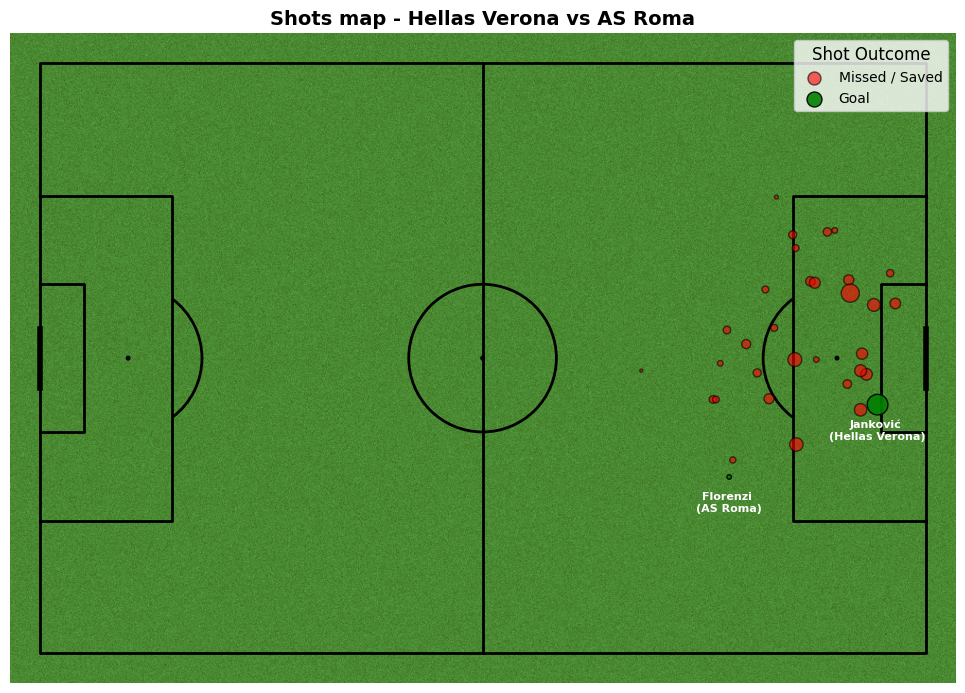

In [205]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Create pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(10, 7))

# Separate goals and non-goals
goals = shots[shots['shot_outcome'] == 'Goal']
others = shots[shots['shot_outcome'] != 'Goal']

# Plot non-goals
pitch.scatter(
    others['location'].apply(lambda x: x[0]),
    others['location'].apply(lambda x: x[1]),
    s=others['shot_statsbomb_xg']*800 if 'shot_statsbomb_xg' in others else 100,
    c='red', edgecolors='black', alpha=0.6, ax=ax, label='Missed / Saved'
)

# Plot goals
pitch.scatter(
    goals['location'].apply(lambda x: x[0]),
    goals['location'].apply(lambda x: x[1]),
    s=goals['shot_statsbomb_xg']*800 if 'shot_statsbomb_xg' in goals else 100,
    c='green', edgecolors='black', alpha=0.9, ax=ax, label='Goal'
)

# Add player names above the goals
for _, row in goals.iterrows():

    x, y = row['location']

    player_name = row['player'].split(' ')[1]
    player_team = row['team']
    name_team = f"{player_name} \n({player_team})"

    ax.text(x, y+5, name_team, color='white', fontsize=8, fontweight='bold',
            ha='center', va='bottom', alpha=1)

# Titles
plt.title(f"Shots map - {first_row.get('home_team', '')} vs {first_row.get('away_team', '')}", 
          fontsize=14, fontweight='bold')
plt.legend(
    fontsize=10,
    title="Shot Outcome",
    title_fontsize='12'
)
plt.show()
